In [45]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import imghdr

In [46]:
import cv2

In [47]:
data_dir = "data"
image_extensions = ["jpeg", "jpg", "bmp", "png"] #List of allowed extensions

In [48]:
os.listdir(data_dir)

['horse', 'dog', 'butterfly', 'cat']

In [49]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_extensions: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)



Loading our data

In [50]:
data = tf.keras.utils.image_dataset_from_directory("data")
#Builds us the dataset and does some preprocessing

Found 257 files belonging to 4 classes.


In [51]:
#The data is a generator so we will convert it to a numpy iterator
data_iterator = data.as_numpy_iterator()

#We will get consecutive batches from .next()

In [52]:
batch = data_iterator.next()
batch

(array([[[[2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
          [2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
          [2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
          ...,
          [2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
          [2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
          [2.55000000e+02, 2.55000000e+02, 2.55000000e+02]],
 
         [[2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
          [2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
          [2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
          ...,
          [2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
          [2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
          [2.55000000e+02, 2.55000000e+02, 2.55000000e+02]],
 
         [[2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
          [2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
          [2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
          ...,
          [2.55000000e+02, 2.55000000e+02, 2.5500

In [53]:
len(batch) #the images and the labels


2

In [54]:
batch[0].shape #We have to index the 0 as we want the shape of the images batch[1] wil refer to the labels

(32, 256, 256, 3)

In [55]:
batch[1]

array([2, 0, 1, 0, 2, 0, 1, 0, 3, 2, 3, 2, 2, 3, 0, 1, 1, 1, 3, 2, 1, 0,
       3, 2, 0, 2, 0, 3, 2, 3, 1, 1], dtype=int32)

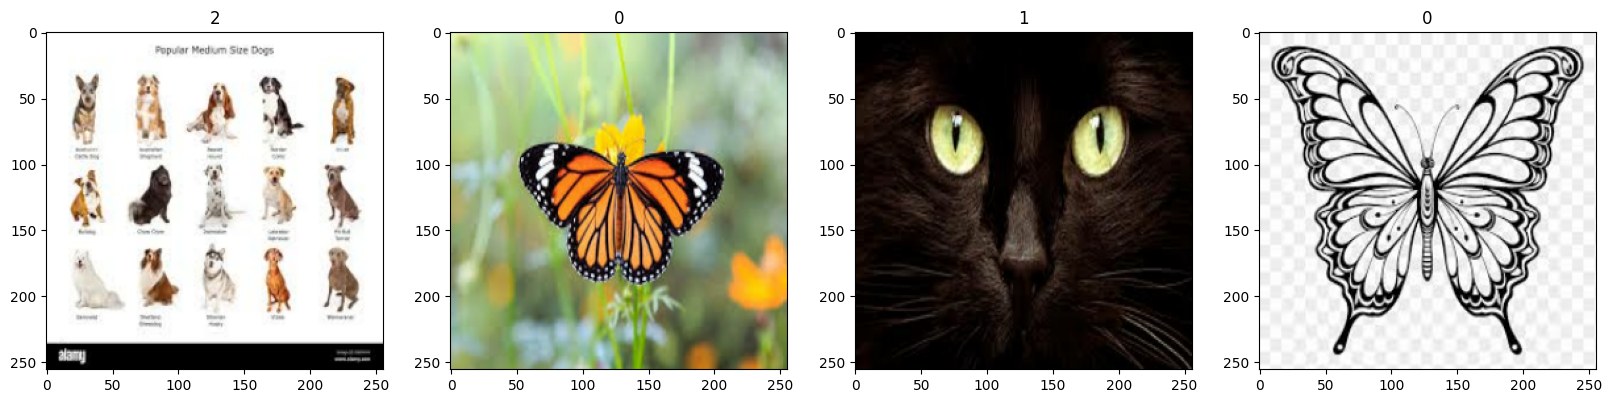

In [56]:
fig, ax = plt.subplots(ncols = 4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

Preprocessing our data

In [57]:
data = data.map(lambda x,y: (x/tf.reduce_max(x), y))
#Every time we fetch our data from the pipeline, it will scale our data between 0 and 1

In [58]:
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()

In [59]:
batch[0].max()

np.float32(1.0)

Splitting our data 

In [60]:
len(data) # no of batches

9

In [61]:
train_size = int(len(data) * .7)
val_size = int(len(data) * .2) + 1
test_size = int(len(data) * .1) + 1 #Adding a one so all batches are used

train_size, val_size, test_size

(6, 2, 1)

In [62]:
#Our data has already been shuffled so we aren't shuffling it here
train_data = data.take(train_size)
val_data = data.skip(train_size).take(val_size)
test_data = data.skip(train_size + val_size).take(test_size)

In [63]:
len(train_data), len(val_data), len(test_data)

(6, 2, 1)

Building the deep learning model

In [64]:
model = tf.keras.Sequential()

In [65]:
#16 filters, kernal_size = (3,3) stride = 1, stride is how many pixels it moves over at once
model.add(tf.keras.layers.Conv2D(16, (3,3), 1, activation="relu", input_shape=(256,256,3)))
model.add(tf.keras.layers.MaxPooling2D()) #returns back the max value that we get from our convolution

model.add(tf.keras.layers.Conv2D(32, (3,3), 1, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(16, (3,3), 1, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(256, activation="relu"))
model.add(tf.keras.layers.Dense(4, activation="softmax"))

In [66]:
model.compile("adam", loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])

In [67]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,697,396 (14.10 MB)

 Trainable params: 3,697,396 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

In [68]:
logdir = "logs"

In [69]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [70]:
history = model.fit(train_data, epochs = 15, validation_data= val_data, callbacks=[tensorboard_callback])

Epoch 1/15


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - accuracy: 0.2000 - loss: 1.6994 - val_accuracy: 0.3750 - val_loss: 1.3545
Epoch 2/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - accuracy: 0.3098 - loss: 1.3420 - val_accuracy: 0.2812 - val_loss: 1.2673
Epoch 3/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.4129 - loss: 1.2105 - val_accuracy: 0.5000 - val_loss: 1.0780
Epoch 4/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - accuracy: 0.6569 - loss: 0.9600 - val_accuracy: 0.6250 - val_loss: 0.8916
Epoch 5/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.6552 - loss: 0.7942 - val_accuracy: 0.8438 - val_loss: 0.6161
Epoch 6/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.8312 - loss: 0.5617 - val_accuracy: 0.7969 - val_loss: 0.6003
Epoch 7/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.7713 - loss: 0.5394 - val_accuracy: 0.9844 - val_loss: 0.3149
Epoch 8/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.9080 - loss: 0.3681 - val_accuracy: 0.9531 - val_loss: 0.2354
Epo

In [71]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

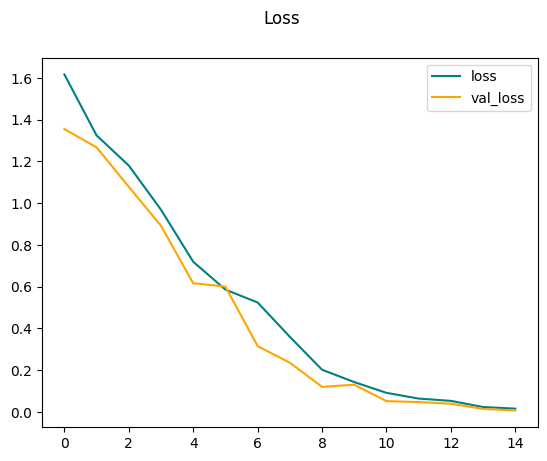

In [72]:
fig = plt.figure()
plt.plot(history.history["loss"], color="teal", label="loss")
plt.plot(history.history["val_loss"], color="orange", label="val_loss")
fig.suptitle("Loss")
plt.legend()
plt.show()

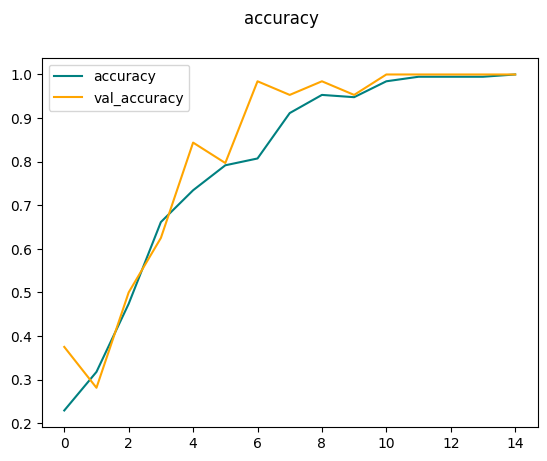

In [73]:
fig = plt.figure()
plt.plot(history.history["accuracy"], color="teal", label="accuracy")
plt.plot(history.history["val_accuracy"], color="orange", label="val_accuracy")
fig.suptitle("accuracy")
plt.legend()
plt.show()

In [74]:
from tensorflow.keras.metrics import Precision, Recall

In [75]:
precision = Precision()
recall = Recall()

In [76]:
len(test_data)

1

In [77]:
for batch in test_data.as_numpy_iterator():
    X, y = batch
    y_pred = model.predict(X)
    y_pred_classes = tf.argmax(y_pred, axis=1)
    precision.update_state(y, y_pred_classes)
    recall.update_state(y, y_pred_classes)

    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


2025-07-15 17:45:56.940568: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [78]:
print("precision:", precision.result().numpy(), "recall", recall.result().numpy())

precision: 1.0 recall 1.0


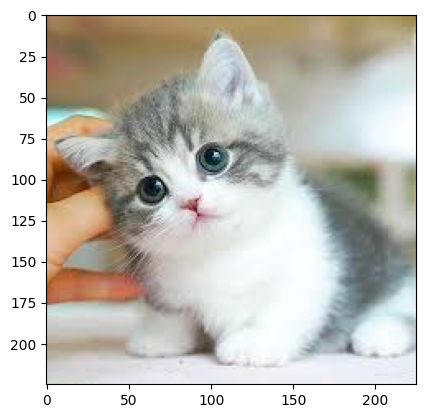

In [79]:
img = cv2.imread("images.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

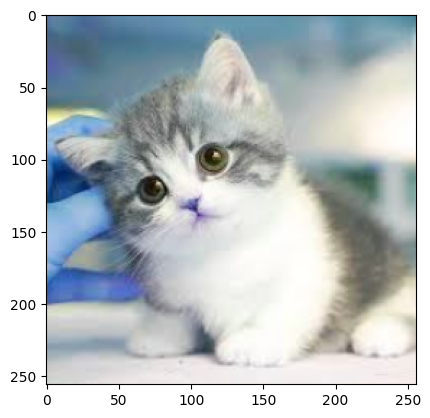

In [80]:
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize/255)

In [81]:
y_pred = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


In [82]:
ans = list(y_pred[0]).index(max(list(y_pred[0])))
if ans == 0:
    print("Butterfly")
elif ans == 1:
    print("Cat")
elif ans == 2:
    print("dog")
elif ans == 3:
    print("horse")


Cat


In [83]:
y_pred

array([[3.6433639e-04, 9.8291773e-01, 1.2583229e-02, 4.1347207e-03]],
      dtype=float32)

In [84]:
print(y_pred)

[[3.6433639e-04 9.8291773e-01 1.2583229e-02 4.1347207e-03]]


Saving the model

In [85]:
model.save(os.path.join("models", "animalclassification.h5"))